In [93]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
n = 100000

# 特徴量の生成
features = np.random.normal(0, 1, size=(n, 5))
df = pd.DataFrame(features, columns=[f'x_{i+1}' for i in range(5)])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# ロジスティック回帰モデルの設定
logistic_model = LogisticRegression()
# x_1 にノイズを加えた値が0を超える場合を目標変数として設定
df['target'] = (df['x_1'] + np.random.normal(0, 0.6, size=n) > 0).astype(int)
# モデル訓練（ここではすべての特徴量を使用）
logistic_model.fit(X_scaled, df['target'])
# 傾向スコアの計算
df['propensity_score'] = logistic_model.predict_proba(X_scaled)[:, 1]

# 傾向スコアに基づいて介入を割り当て
df['treatment'] = np.random.binomial(1, df['propensity_score'])

# 訪問と購入の確率を計算
prob_visit = 0.3 + df['treatment'] * 0.4 + df['x_2'] * 0.1
df['visit'] = np.random.binomial(1, np.clip(prob_visit, 0, 1))
prob_purchase = 0.1 + df['treatment'] * 0.2 + df['x_3'] * 0.05
df['purchase'] = np.where(df['visit'] == 1, np.random.binomial(1, np.clip(prob_purchase, 0, 1)), 0)

# 結果の表示
df.head()


,x_1,x_2,x_3,x_4,x_5,target,propensity_score,treatment,visit,purchase
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,0,0.804899,0,0,0
1,-0.234137,1.579213,0.767435,-0.469474,0.542560,0,0.339087,1,1,1
2,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,0,0.212084,0,0,0
3,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0,0.164477,0,0,0
4,1.465649,-0.225776,0.067528,-1.424748,-0.544383,1,0.986768,1,0,0


In [98]:
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# propensity_model = LogisticRegression()
X = df.drop(columns=["target", "propensity_score", "treatment", "visit", "purchase"])
# propensity_model.fit(df_X, df["T"])
# propensities = propensity_model.predict_proba(df_X)[:, 1]
# df["propensity"] = propensities
# T=1の時 y / propensityを，T=0の時 y / (1 - propensity)を計算
df["y_r_ipw"] = np.where(df["treatment"]==1, df["purchase"] / df["propensity_score"], df["purchase"] / (1 - df["propensity_score"]))
df["y_c_ipw"] = np.where(df["treatment"]==1, df["visit"] / df["propensity_score"], df["visit"] / (1 - df["propensity_score"]))

X_train, X_test, T_train, T_test, y_r_train, y_r_test, y_c_train, y_c_test, y_r_ipw_train, y_r_ipw_test, y_c_ipw_train, y_c_ipw_test = train_test_split(X, df["treatment"],df["purchase"], df["visit"], df["y_r_ipw"], df["y_c_ipw"], train_size=0.7, random_state=0, stratify=df["treatment"])

T_test = T_test.reset_index(drop=True)
y_r_test = y_r_test.reset_index(drop=True)
y_c_test = y_c_test.reset_index(drop=True)


In [109]:
import lightgbm as lgb

def custom_objective(y_pred: np.ndarray, train_data: lgb.Dataset):
    y_r = y_r_ipw_train
    y_c = y_c_ipw_train
    t = T_train.values
    treatment = (t == 1)
    control = (t == 0)

    N_1 = np.sum(treatment)
    N_0 = np.sum(control)

    p = 1 / (1 + np.exp(-y_pred))

    grad = ((-1) ** t) * (y_r - y_c * p) / np.where(treatment, N_1, N_0)

    hess = y_c * p * (1 - p) / np.where(treatment, N_1, N_0)

    return grad, hess

def get_roi_direct():
    dtrain = lgb.Dataset(X_train, free_raw_data=False)

    params = {
        'objective': lambda y_pred, train_data: custom_objective(y_pred, train_data),
        'verbose': -1,
    }
    bst = lgb.train(params, dtrain)
    roi_direct = bst.predict(X_test, num_iteration=bst.best_iteration)
    roi_direct = 1 / (1 + np.exp(-roi_direct))
    return roi_direct

def get_roi_tpmsl():
    # 必要なライブラリのインポート
    from sklearn.ensemble import RandomForestRegressor
    from econml.metalearners import SLearner
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import MinMaxScaler
    from lightgbm import LGBMRegressor


    # モデルの構築
    models = LGBMRegressor()
    # models = LinearRegression()
    S_learner_r = SLearner(overall_model = models)
    S_learner_r.fit(y_r_train, T_train, X = X_train)

    S_learner_c = SLearner(overall_model = models)
    S_learner_c.fit(y_c_train, T_train, X = X_train)

    # 効果の推定
    tau_r = S_learner_r.effect(X_test)
    tau_c = S_learner_c.effect(X_test)
    roi_tpmsl = tau_r / tau_c

    scaler = MinMaxScaler()
    roi_tpmsl = scaler.fit_transform(roi_tpmsl.reshape(-1, 1)).flatten()

    # roi_tpmsl = sigmoid(roi_tpmsl)
    return roi_tpmsl

def calculate_values(roi_scores):
    sorted_indices = np.argsort(roi_scores)[::-1]
    p_values = np.linspace(0, 1, 30)
    incremental_costs = []
    incremental_values = []
    
    for p in p_values:
        top_p_indices = sorted_indices[:int(p * len(roi_scores))]
        treatment_indices = (T_test[top_p_indices] == 1)
        
        # ATE (Average Treatment Effect) の計算
        ATE_Yr = np.mean(y_r_test[top_p_indices][treatment_indices]) - np.mean(y_r_test[top_p_indices][~treatment_indices])
        ATE_Yc = np.mean(y_c_test[top_p_indices][treatment_indices]) - np.mean(y_c_test[top_p_indices][~treatment_indices])
        
        incremental_costs.append(ATE_Yc * np.sum(treatment_indices))
        incremental_values.append(ATE_Yr * np.sum(treatment_indices))
        # print(ATE_Yr , ATE_Yc,np.sum(treatment_indices))
        incremental_costs[0] = 0
        incremental_values[0] = 0
        
    return incremental_costs, incremental_values

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import cost_aware

roi_direct = get_roi_direct()
roi_tpmsl = get_roi_tpmsl()

# それぞれのデータセットについて計算
incremental_costs_tpmsl, incremental_values_tpmsl = calculate_values(roi_tpmsl)
incremental_costs_direct, incremental_values_direct = calculate_values(roi_direct)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 9
[LightGBM] [Info] Start training from score 0.119314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

invalid value encountered in divide
All-NaN slice encountered
All-NaN slice encountered


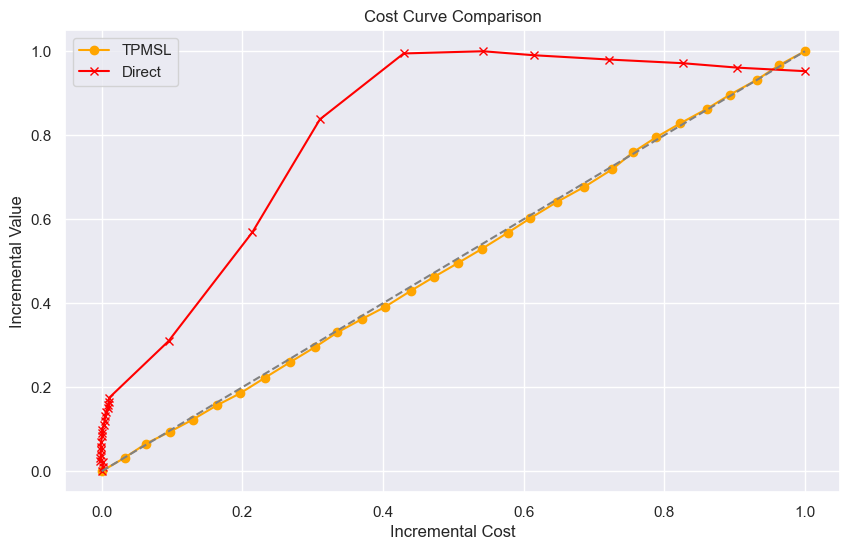

In [111]:
# 横軸と縦軸を正規化してグラフ描画
plt.figure(figsize=(10, 6))
plt.plot(incremental_costs_tpmsl / max(incremental_costs_tpmsl), incremental_values_tpmsl / max(incremental_values_tpmsl), marker='o', color='orange',  label='TPMSL')
plt.plot(incremental_costs_direct / max(incremental_costs_direct), incremental_values_direct / max(incremental_values_direct), marker='x', color='red', label='Direct')
# y = x の直線
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Cost Curve Comparison')
plt.xlabel('Incremental Cost')
plt.ylabel('Incremental Value')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import lightgbm as lgb
def custom_objective(y_pred: np.ndarray, train_data: lgb.Dataset):
    y = train_data.get_label()
    t = T_train.values

    treatment = (t == 1)
    control = (t == 0)

    N_1 = np.sum(treatment)
    N_0 = np.sum(control)

    exp_scores = np.exp(y_pred - np.max(y_pred))
    sum_exp_scores = np.sum(exp_scores)
    p = exp_scores / sum_exp_scores

    sum_y_treat = np.sum(y[treatment])
    sum_y_control = np.sum(y[control])

    grad = (p * sum_y_treat / N_1) - (p * sum_y_control / N_0)

    # (-1)^t(k) * y_k / N_t(k) 項の計算
    last_term = ((-1) ** treatment) * y / np.where(treatment, N_1, N_0)
    grad += last_term
    p_one_minus_p = p * (1 - p)
    hess = (p_one_minus_p * sum_y_treat / N_1) - (p_one_minus_p * sum_y_control / N_0)

    return grad, hess

def get_tau_direct():
    # データセットの作成
    dtrain = lgb.Dataset(X_train, label=y_train)
    # LightGBMのパラメータ
    params = {
        'objective': lambda y_pred, train_data: custom_objective(y_pred, train_data)
        }

    # モデルの訓練
    bst = lgb.train(params, dtrain)

    # テストデータセットに対する予測
    tau_direct = bst.predict(X_test, num_iteration=bst.best_iteration)

    return tau_direct

tau_direct = get_tau_direct()

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 2
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [26]:
X_test["x_1"]+X_test["x_2"]

297    0.029112
828   -0.191645
626    1.507301
416   -1.318169
225    0.394723
         ...   
745   -0.225012
627    0.722210
716   -0.623503
572   -1.015192
934   -0.752744
Length: 300, dtype: float64

In [28]:
tau_direct.min(), tau_direct.max()

(-9.03202769664608, 1.6976513644829136)

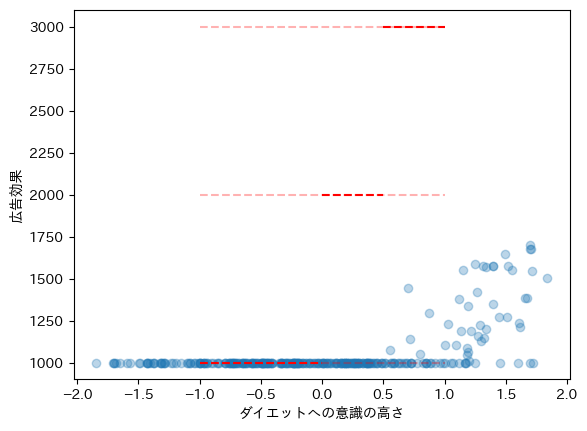

In [40]:
plt.scatter(X_test["x_1"]+X_test["x_2"], tau_direct, alpha=0.3)
plt.hlines(1000, -1, 0, linestyles='--', color="red")
plt.hlines(1000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(2000, 0, 0.5, linestyles='--', color="red")
plt.hlines(2000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(3000, 0.5, 1.0, linestyles='--', color="red")
plt.hlines(3000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.xlabel("ダイエットへの意識の高さ")
plt.ylabel("広告効果")
# plt.ylim(0, 4000)
plt.show()

In [37]:
np.clip?

Signature:       np.clip(a, a_min, a_max, out=None, **kwargs)
Call signature:  np.clip(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function clip at 0x1082acee0>
File:            ~/python/coupon/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py
Docstring:      
Clip (limit) the values in an array.

Given an interval, values outside the interval are clipped to
the interval edges.  For example, if an interval of ``[0, 1]``
is specified, values smaller than 0 become 0, and values larger
than 1 become 1.

Equivalent to but faster than ``np.minimum(a_max, np.maximum(a, a_min))``.

No check is performed to ensure ``a_min < a_max``.

Parameters
----------
a : array_like
    Array containing elements to clip.
a_min, a_max : array_like or None
    Minimum and maximum value. If ``None``, clipping is not performed on
    the corresponding edge. Only one of `a_min` and `a_max` may be
    ``None``. Both are broadcast against `a`.
out : ndarray, optional
  

### S Learner

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 4
[LightGBM] [Info] Start training from score 1534.285714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

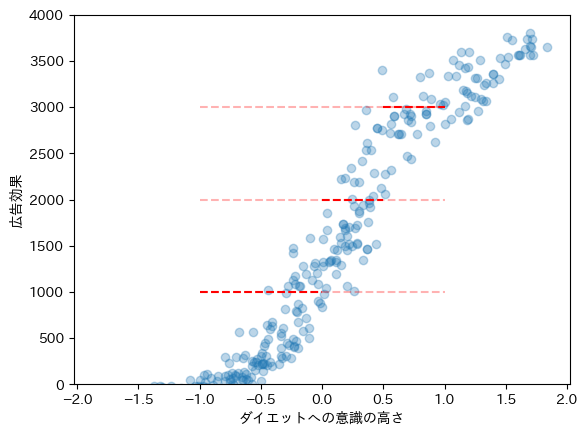

In [23]:
# 必要なライブラリのインポート
from lightgbm import LGBMRegressor
from econml.metalearners import SLearner
from sklearn.linear_model import LinearRegression

# モデルの構築
# models = LGBMRegressor()
models = LGBMRegressor()
S_learner = SLearner(overall_model=models)
S_learner.fit(y_train, T_train, X = X_train)

# 効果の推定
tau_sl = S_learner.effect(X_test)

# 推定された効果の描画
plt.scatter(X_test["x_1"]+X_test["x_2"], tau_sl, alpha=0.3)
plt.hlines(1000, -1, 0, linestyles='--', color="red")
plt.hlines(1000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(2000, 0, 0.5, linestyles='--', color="red")
plt.hlines(2000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(3000, 0.5, 1.0, linestyles='--', color="red")
plt.hlines(3000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.xlabel("ダイエットへの意識の高さ")
plt.ylabel("広告効果")
plt.ylim(0, 4000)
plt.show()

### X Learner

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 350, number of used features: 2
[LightGBM] [Info] Start training from score 185.714286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

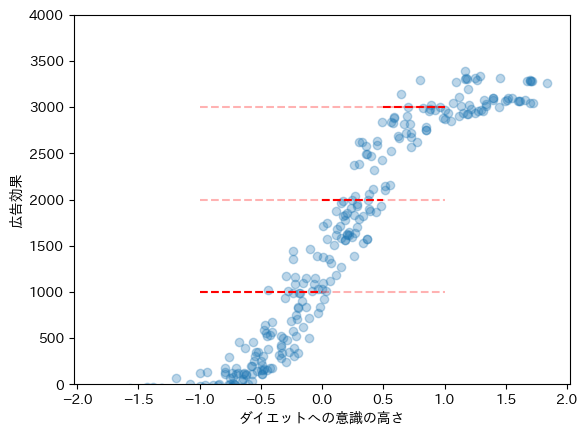

In [24]:
# 必要なライブラリのインポート
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from econml.metalearners import XLearner

# モデルの構築
models = LGBMRegressor()
propensity_model = LogisticRegression()
X_learner = XLearner(models=models, propensity_model=propensity_model)
X_learner.fit(y_train, T_train, X = X_train)

# 効果の推定
tau_xl = X_learner.effect(X_test)

# 推定された効果の可視化
plt.scatter(X_test["x_1"]+X_test["x_2"], tau_xl, alpha=0.3)
plt.hlines(1000, -1, 0, linestyles='--', color="red")
plt.hlines(1000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(2000, 0, 0.5, linestyles='--', color="red")
plt.hlines(2000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(3000, 0.5, 1.0, linestyles='--', color="red")
plt.hlines(3000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.xlabel("ダイエットへの意識の高さ")
plt.ylabel("広告効果")
plt.ylim(0, 4000)
plt.show()

### 提案手法

In [475]:
df_X

,x_1,x_2
0,0.097627,0.185761
1,0.430379,-0.979873
2,0.205527,-0.048348
3,0.089766,0.417541
4,-0.152690,-0.912049
...,...,...
995,-0.804647,0.582563
996,0.029844,0.442396
997,0.876824,-0.039784
998,-0.542707,0.287728


In [493]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# データをテンソルに変換
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_ipw_train_tensor = torch.tensor(y_ipw_train.values, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train.values, dtype=torch.float32)
tau_train_tensor = torch.tensor(tau_train.values, dtype=torch.float32)

# # データをテンソルに変換してDatasetを作成
# dataset_1 = TensorDataset(X_train_tensor[T_train_tensor == 1], y_ipw_train_tensor[T_train_tensor == 1], tau_train_tensor[T_train_tensor == 1])
# dataset_0 = TensorDataset(X_train_tensor[T_train_tensor == 0], y_ipw_train_tensor[T_train_tensor == 0], tau_train_tensor[T_train_tensor == 0])

# # DataLoaderを作成
# batch_size = 64  # バッチサイズを設定
# loader_1 = DataLoader(dataset_1, batch_size=len(dataset_1), shuffle=True)
# loader_0 = DataLoader(dataset_0, batch_size=len(dataset_0), shuffle=True)

loader = DataLoader(TensorDataset(X_train_tensor, y_ipw_train_tensor, T_train_tensor, tau_train_tensor), batch_size=70, shuffle=True)

class NonLinearModel(nn.Module):
    def __init__(self, input_dim):
        super(NonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4)
        # self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(4, 7)
        # self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(7, 4)
        # self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(4, 1)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        # x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        # x = self.dropout3(x)
        x = self.fc4(x)

        return x

def loss_function(scores, tau):
    probabilities = torch.softmax(scores, dim=0)
    probabilities = torch.clamp(probabilities, 1e-6, 1 - 1e-6)
    loss = -torch.mean(tau * torch.log(probabilities))
    return loss

# モデルのインスタンス化
model = NonLinearModel(X_train_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.4)

loss_history = []  # 損失を記録するリストを初期化

# トレーニングループ
for epoch in range(300):
    model.train()
    total_loss = 0
    total_batches = 0
    
    # データローダーを通してバッチ処理
    # for (x_1, y_1, tau_1), (x_0, y_0, tau_0) in tqdm(zip(loader_1, loader_0)):
    for x, y, t, tau in tqdm(loader):
        optimizer.zero_grad()

        # モデルによるスコアの計算
        scores = model(x)

        # 損失の計算
        loss = loss_function(scores, tau)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_batches += 1

    average_loss = total_loss / total_batches
    loss_history.append(average_loss) 
    scheduler.step()  # スケジューラをステップする

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Average Loss: {average_loss}')



100%|██████████| 10/10 [00:00<00:00, 564.49it/s]


Epoch 0, Average Loss: 7.6897780418396


100%|██████████| 10/10 [00:00<00:00, 1267.77it/s]


Epoch 10, Average Loss: 7.6897765636444095


100%|██████████| 10/10 [00:00<00:00, 905.08it/s]


Epoch 20, Average Loss: 7.689776372909546


100%|██████████| 10/10 [00:00<00:00, 1268.69it/s]


Epoch 30, Average Loss: 7.689776420593262


100%|██████████| 10/10 [00:00<00:00, 1331.02it/s]


Epoch 40, Average Loss: 7.689776754379272


100%|██████████| 10/10 [00:00<00:00, 1319.09it/s]


Epoch 50, Average Loss: 7.689776468276977


100%|██████████| 10/10 [00:00<00:00, 1237.73it/s]


Epoch 60, Average Loss: 7.6897765636444095


100%|██████████| 10/10 [00:00<00:00, 1339.05it/s]


Epoch 70, Average Loss: 7.689776611328125


100%|██████████| 10/10 [00:00<00:00, 1252.33it/s]


Epoch 80, Average Loss: 7.6897767066955565


100%|██████████| 10/10 [00:00<00:00, 1125.26it/s]


Epoch 90, Average Loss: 7.68977632522583


100%|██████████| 10/10 [00:00<00:00, 1157.69it/s]


Epoch 100, Average Loss: 7.689776659011841


100%|██████████| 10/10 [00:00<00:00, 1313.72it/s]


Epoch 110, Average Loss: 7.689776420593262


100%|██████████| 10/10 [00:00<00:00, 1160.67it/s]


Epoch 120, Average Loss: 7.6897765636444095


100%|██████████| 10/10 [00:00<00:00, 1244.71it/s]


Epoch 130, Average Loss: 7.68977632522583


100%|██████████| 10/10 [00:00<00:00, 1304.81it/s]


Epoch 140, Average Loss: 7.689776659011841


100%|██████████| 10/10 [00:00<00:00, 1162.79it/s]


Epoch 150, Average Loss: 7.689776277542114


100%|██████████| 10/10 [00:00<00:00, 1074.80it/s]


Epoch 160, Average Loss: 7.689776611328125


100%|██████████| 10/10 [00:00<00:00, 1300.40it/s]


Epoch 170, Average Loss: 7.689776468276977


100%|██████████| 10/10 [00:00<00:00, 1296.54it/s]


Epoch 180, Average Loss: 7.689776420593262


100%|██████████| 10/10 [00:00<00:00, 1315.28it/s]


Epoch 190, Average Loss: 7.689776515960693


100%|██████████| 10/10 [00:00<00:00, 1233.98it/s]


Epoch 200, Average Loss: 7.68977632522583


100%|██████████| 10/10 [00:00<00:00, 1321.83it/s]


Epoch 210, Average Loss: 7.689776515960693


100%|██████████| 10/10 [00:00<00:00, 1210.69it/s]


Epoch 220, Average Loss: 7.689776611328125


100%|██████████| 10/10 [00:00<00:00, 1179.97it/s]


Epoch 230, Average Loss: 7.689776420593262


100%|██████████| 10/10 [00:00<00:00, 1061.12it/s]


Epoch 240, Average Loss: 7.68977632522583


100%|██████████| 10/10 [00:00<00:00, 1206.16it/s]


Epoch 250, Average Loss: 7.689776468276977


100%|██████████| 10/10 [00:00<00:00, 1252.07it/s]


Epoch 260, Average Loss: 7.689776515960693


100%|██████████| 10/10 [00:00<00:00, 1308.39it/s]


Epoch 270, Average Loss: 7.689776372909546


100%|██████████| 10/10 [00:00<00:00, 1214.33it/s]


Epoch 280, Average Loss: 7.689776515960693


100%|██████████| 10/10 [00:00<00:00, 1291.35it/s]


Epoch 290, Average Loss: 7.689776468276977


100%|██████████| 10/10 [00:00<00:00, 1271.58it/s]


In [504]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

np.random.seed(42)  # 乱数のシードを設定

# データの生成
n = 1000  # サンプルサイズ
x = np.random.uniform(-1, 1, n)  # -1から1までの一様分布
noise = np.random.normal(0, 0.1, n)  # ノイズは正規分布

# 治療割当を決定
T = (x + noise > 0).astype(int)

# アウトカムの生成
Y = 1000 * (3 + 7 * T + 3 * x + noise)

# サブグループの割り当て
tau = np.zeros_like(x, dtype=int)
tau[x <= 0] = 1
tau[(x > 0) & (x <= 0.5)] = 2
tau[x > 0.5] = 3

# Pandas DataFrameに変換
df = pd.DataFrame({'x': x, 'T': T, 'Y': Y, 'tau': tau})

# データをテンソルに変換してPyTorchのデータローダーを設定
X_tensor = torch.tensor(df[['x']].values, dtype=torch.float32)
Y_tensor = torch.tensor(df['Y'].values, dtype=torch.float32)
T_tensor = torch.tensor(df['T'].values, dtype=torch.float32)
tau_tensor = torch.tensor(df['tau'].values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, Y_tensor, T_tensor, tau_tensor)
loader = DataLoader(dataset, batch_size=1000, shuffle=True)

# モデルの定義
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# モデルとオプティマイザの初期化
model = RegressionModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_history = []  # 損失を記録するリストを初期化
# トレーニングループ
for epoch in tqdm(range(100)):
    for x_batch, y_batch, t_batch, tau_batch in loader:
        optimizer.zero_grad()
        predictions = model(x_batch).squeeze()
        loss = torch.mean(tau_batch * torch.log(torch.softmax(predictions, dim=0)))
        loss.backward()
        optimizer.step()


    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    loss_history.append(loss.item())

# 生成したデータと学習したモデルの評価
x_test = torch.linspace(-1, 1, 100).unsqueeze(1)
with torch.no_grad():
    tau_direct = torch.exp(model(x_test))



  0%|          | 0/100 [00:00<?, ?it/s]

 19%|█▉        | 19/100 [00:00<00:00, 101.26it/s]

-11.989287376403809
Epoch 0, Loss: -11.989287376403809
-12.01371955871582
-12.039950370788574
-12.068164825439453
-12.098543167114258
-12.131166458129883
-12.166192054748535
-12.203873634338379
-12.244483947753906
-12.288251876831055
-12.335408210754395
Epoch 10, Loss: -12.335408210754395
-12.38619613647461
-12.440877914428711
-12.49972915649414
-12.563054084777832
-12.631193161010742
-12.704485893249512
-12.783307075500488
-12.86805248260498
-12.959150314331055
-13.057012557983398
Epoch 20, Loss: -13.057012557983398
-13.162097930908203
-13.274858474731445


 58%|█████▊    | 58/100 [00:00<00:00, 162.82it/s]

-13.395715713500977
-13.525113105773926
-13.663482666015625
-13.81122875213623
-13.968705177307129
-14.136208534240723
-14.31401538848877
-14.502384185791016
Epoch 30, Loss: -14.502384185791016
-14.701574325561523
-14.911785125732422
-15.133164405822754
-15.365861892700195
-15.609999656677246
-15.865718841552734
-16.13306999206543
-16.41219711303711
-16.703125
-17.00593376159668
Epoch 40, Loss: -17.00593376159668
-17.320724487304688
-17.64748764038086
-17.986312866210938
-18.337207794189453
-18.70018196105957
-19.075265884399414
-19.462421417236328
-19.860107421875
-20.270254135131836
-20.692428588867188
Epoch 50, Loss: -20.692428588867188
-21.126737594604492
-21.57326316833496
-22.032024383544922
-22.5030460357666
-22.98638153076172
-23.482044219970703
-23.989601135253906
-24.508607864379883
-25.039579391479492
-25.582775115966797
Epoch 60, Loss: -25.582775115966797


 94%|█████████▍| 94/100 [00:00<00:00, 99.43it/s] 

-26.138309478759766
-26.706146240234375
-27.286378860473633
-27.879032135009766
-28.484012603759766
-29.101383209228516
-29.731149673461914
-30.37324333190918
-31.02773094177246
-31.694547653198242
Epoch 70, Loss: -31.694547653198242
-32.37367630004883
-33.06514358520508
-33.76903533935547
-34.485374450683594
-35.21413040161133
-35.9553108215332
-36.70896530151367
-37.475093841552734
-38.25368118286133
-39.0446662902832
Epoch 80, Loss: -39.0446662902832
-39.848052978515625
-40.66379928588867
-41.49198913574219
-42.33262634277344
-43.18566131591797
-44.051124572753906
-44.92898941040039
-45.81930923461914
-46.72206115722656
-47.637168884277344
Epoch 90, Loss: -47.637168884277344
-48.564659118652344
-49.50455856323242
-50.45682907104492
-51.42144012451172
-52.3984260559082
-53.387779235839844
-54.389461517333984


100%|██████████| 100/100 [00:00<00:00, 104.73it/s]

-55.40349578857422
-56.429866790771484


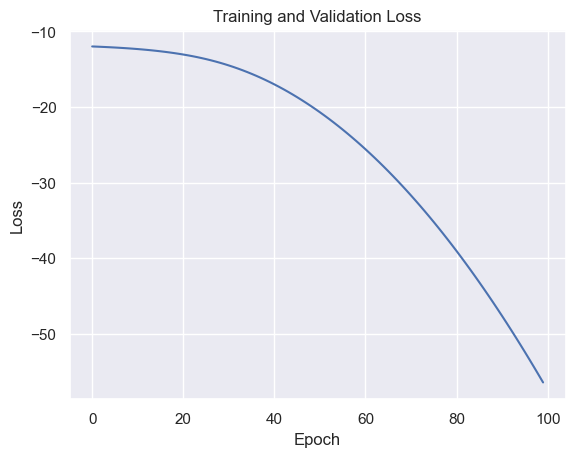

In [505]:
# model.eval()
# with torch.no_grad():
#     s_test = model(torch.tensor(X_test.values, dtype=torch.float32))
#     tau_direct = 1000 * torch.exp(s_test)
#     tau_direct = tau_direct.reshape(1, -1)[0]

# 損失の可視化
plt.plot(loss_history)
# plt.plot(loss_history_val)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [513]:
len(tau_direct)

100

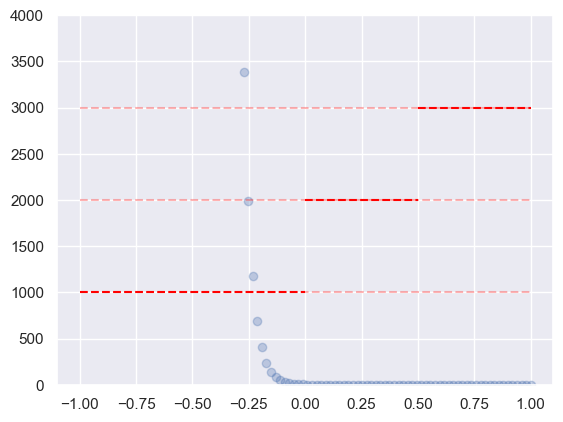

In [515]:
plt.scatter(x_test, tau_direct, alpha=0.3)
plt.hlines(1000, -1, 0, linestyles='--', color="red")
plt.hlines(1000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(2000, 0, 0.5, linestyles='--', color="red")
plt.hlines(2000, -1, 1, linestyles='--', color="red", alpha=0.3)
plt.hlines(3000, 0.5, 1.0, linestyles='--', color="red")
plt.hlines(3000, -1, 1, linestyles='--', color="red", alpha=0.3)
# plt.xlabel("ダイエットへの意識の高さ")
# plt.ylabel("広告効果")
# plt.xlim(-0.9, 1.1)
plt.ylim(0, 4000)
plt.show()

In [382]:
df_direct

,X,s,tau
0,-0.305533,0.335105,139.808670
2,0.275165,0.323035,138.131409
4,-0.072849,0.324244,138.298431
5,-0.270176,0.332104,139.389816
6,-0.085882,0.324289,138.304688
...,...,...,...
294,-0.201949,0.328037,138.823990
295,0.983781,0.331498,139.305344
296,0.396497,0.322614,138.073212
297,0.685554,0.323257,138.162048


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler
from tqdm import tqdm

# データをテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_ipw_train_tensor = torch.tensor(y_ipw_train, dtype=torch.float32)
T_train_tensor = torch.tensor(T_train, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
# T_val_tensor = torch.tensor(T_val.values, dtype=torch.float32)

# データをテンソルに変換してDatasetを作成
dataset_1 = TensorDataset(X_train_tensor[T_train_tensor == 1], y_ipw_train_tensor[T_train_tensor == 1])
dataset_0 = TensorDataset(X_train_tensor[T_train_tensor == 0], y_ipw_train_tensor[T_train_tensor == 0])
# dataset_1_val = TensorDataset(X_val_tensor[T_val_tensor == 1], y_val_tensor[T_val_tensor == 1])
# dataset_0_val = TensorDataset(X_val_tensor[T_val_tensor == 0], y_val_tensor[T_val_tensor == 0])

# DataLoaderの定義
loader_1 = DataLoader(dataset_1, batch_size=70, shuffle=True)
loader_0 = DataLoader(dataset_0, batch_size=70, shuffle=True)
# loader_1_val = DataLoader(dataset_1_val, batch_size=170, shuffle=True)
# loader_0_val = DataLoader(dataset_0_val, batch_size=30, shuffle=True)

# 非線形モデルの定義
class NonLinearModel(nn.Module):
    def __init__(self, input_dim):
        super(NonLinearModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 2)
        self.fc2 = nn.Linear(2, 3)
        self.fc3 = nn.Linear(3, 2)
        self.fc4 = nn.Linear(2, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)

        return x


# model = LogisticRegressionModel(X_train_tensor.shape[1])
model = NonLinearModel(X_train_tensor.shape[1])

# 損失関数の定義
def custom_loss(y, q, group_size):
    # qが0になるのを防ぐ
    q = torch.clamp(q, 1e-8, 1 - 1e-8)

    # 損失計算
    loss = -torch.sum(y * torch.log(q)) / group_size
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.0001)
# 1. LambdaLR
# lambda_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)

loss_history, loss_history_val = [], []  # 損失を記録するリストを初期化


for epoch in range(30):
    model.train()
    total_loss = 0
    count_batches = 0
    for (x_1, y_1), (x_0, y_0) in tqdm(zip(loader_1, loader_0)):
        optimizer.zero_grad()
        
        s_1 = model(x_1)
        s_0 = model(x_0)

        q_1 = torch.softmax(s_1, dim=0)
        q_0 = torch.softmax(s_0, dim=0)

        loss_1 = custom_loss(y_1, q_1, x_1.size(0))
        loss_0 = custom_loss(y_0, q_0, x_0.size(0))
        
        loss = loss_1 - loss_0
        # 1回だけlossをprint
        # if count_batches == 0:
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # 総損失に今回のバッチの損失を加算
        count_batches += 1

    average_loss = total_loss / count_batches  # このエポックの平均損失
    loss_history.append(average_loss)  # 損失履歴に追加



    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Average Loss: {average_loss}')


497it [00:00, 1152.11it/s]


Epoch 0, Average Loss: 782328.3604124748


497it [00:00, 1232.07it/s]
497it [00:00, 1125.10it/s]
497it [00:00, 1190.70it/s]
497it [00:00, 1216.19it/s]
497it [00:00, 1231.37it/s]
497it [00:00, 1177.52it/s]
497it [00:00, 1205.66it/s]
497it [00:00, 1202.93it/s]
497it [00:00, 1214.73it/s]
497it [00:00, 1216.51it/s]


Epoch 10, Average Loss: 782826.7988556338


497it [00:00, 1213.78it/s]
497it [00:00, 1158.65it/s]
497it [00:00, 1212.97it/s]
497it [00:00, 1214.85it/s]
497it [00:00, 1192.28it/s]
497it [00:00, 1221.46it/s]
497it [00:00, 1183.77it/s]
497it [00:00, 1229.82it/s]
497it [00:00, 1214.83it/s]
497it [00:00, 1201.39it/s]


Epoch 20, Average Loss: 782215.647887324


497it [00:00, 1164.58it/s]
497it [00:00, 1204.59it/s]
497it [00:00, 1201.67it/s]
497it [00:00, 1203.92it/s]
497it [00:00, 1231.40it/s]
497it [00:00, 1210.32it/s]
497it [00:00, 1231.27it/s]
497it [00:00, 1167.77it/s]
497it [00:00, 1120.87it/s]
